In [1]:
%load_ext autoreload
%autoreload 2

In [133]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import Model
from dropout import *

from data import generate_data
from train import train_main_model, train_deup
from utils import inv_sigmoid, evaluate_and_plot, eval_error

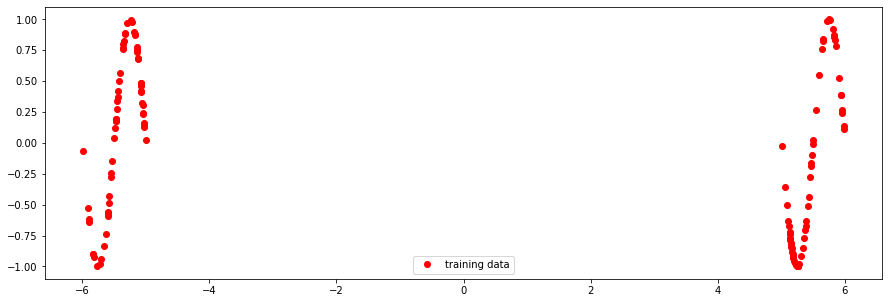

In [134]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 24, 24, seed=7, plot=True, one_sine=False,
                                                                     distance=10.5, shuffle=True, offset=-5.5)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [ ]:
# Multiplicative Gaussian
n_hidden = 256
hidden_layers = 4
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(0.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=MultiplicativeGaussian, mu=None, logsigma=logsigma,
                              noise_generator=noise_generator)
print([x[0] for x in model.named_parameters()])

In [131]:
# Simple Dropout
n_hidden = 256
hidden_layers = 4
lr = 1e-3
p = 0.2

model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=SimpleDropout, p=p).cuda()
print([x[0] for x in model.named_parameters()])

['model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'model.hidden_layer4.weight', 'model.hidden_layer4.bias', 'model.output_layer.weight', 'model.output_layer.bias']


# prior

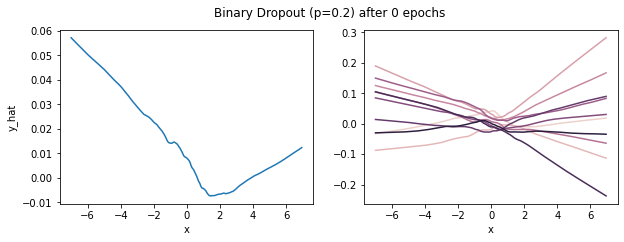

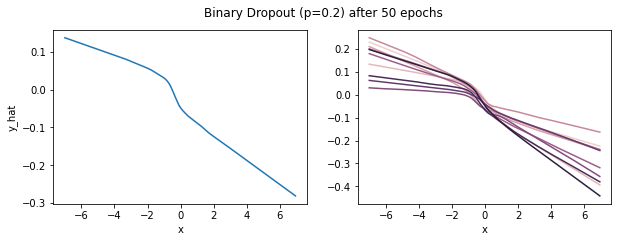

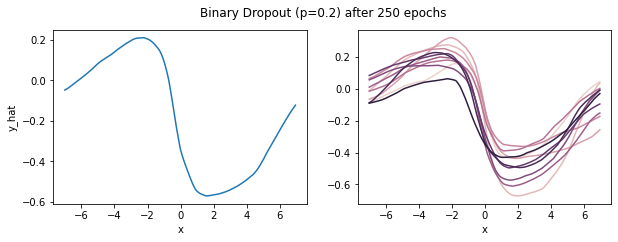

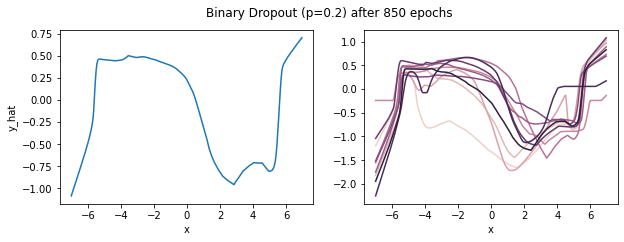

In [132]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)

total_epochs_trained = 0
total_losses = []
total_valid_losses = []
for epochs_to_train in [50, 200, 600, 0]:
    
    model.eval()
    uniform_X = torch.arange(-7, 7, 0.05).unsqueeze(1)
    full_Y_hat_nodo = model(uniform_X.cuda())
    model.train()
    full_Y_hat = []
    for _ in range(10):
        full_Y_hat.append(model(uniform_X.cuda()))
    
    plt.figure(figsize=(10, 3.2))
    bigdf = []
    for i in range(10):
        bigdf.append(pd.DataFrame({'y_hat': full_Y_hat[i].view(-1).tolist(), 'x': uniform_X.view(-1).tolist()}))
        bigdf[-1]['id'] = i

    plt.subplot(1, 2, 1)
    nodo = pd.DataFrame({'y_hat': full_Y_hat_nodo.view(-1).tolist(), 'x': uniform_X.view(-1).tolist()})
    ax = sns.lineplot(data=nodo, x='x', y='y_hat')

    plt.subplot(1, 2, 2)
    bigdf = pd.concat(bigdf)
    ax = sns.lineplot(data=bigdf, x='x', y='y_hat', hue='id', legend=None)
    ax.set_ylabel('')
    plt.suptitle(f'Binary Dropout (p={p}) after {total_epochs_trained} epochs')
    
    losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x.cuda(), y.cuda()),
                                           TensorDataset(oos_x.cuda(), oos_y.cuda()),
                                           epochs=epochs_to_train, batch_size=32)
    total_losses += losses
    total_valid_losses += valid_losses
    total_epochs_trained += epochs_to_train

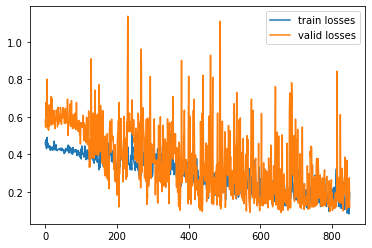

In [125]:
plt.plot(total_losses, label='train losses')
plt.plot(total_valid_losses, label='valid losses')
plt.legend()

# some training

In [ ]:
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=200, batch_size=32)

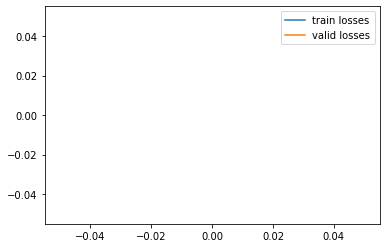

In [57]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [ ]:
params = [y for x, y in model.named_parameters() if 'noise_generator' in x]
print([x for x, y in model.named_parameters() if 'noise_generator' in x])
optimizer = torch.optim.Adam(params, lr=lr)
losses = train_deup(model, optimizer, full_data, epochs=500, batch_size=32, n_samples=5, parametric_noise=True, x_input=True)

In [ ]:
plt.plot(losses)

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=True, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=True, x_input=True).item())

### Same but with neuronwise dropout

In [ ]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(-2.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, n_hidden))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=MultiplicativeGaussian, mu=None, logsigma=logsigma,
                              noise_generator=noise_generator)
print([x[0] for x in model.named_parameters()])
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)

In [ ]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [ ]:
params = [y for x, y in model.named_parameters() if 'noise_generator' in x]
print([x for x, y in model.named_parameters() if 'noise_generator' in x])
optimizer = torch.optim.Adam(params, lr=lr)
losses = train_deup(model, optimizer, full_data, epochs=500, batch_size=32, n_samples=5, parametric_noise=True, x_input=True)

In [ ]:
plt.plot(losses)

In [ ]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=True, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=True, x_input=True).item())